<a href="https://colab.research.google.com/github/osiriszjq/complex_encoding/blob/main/complex_encoding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Complex encoding

This notebook is a template implementation of our complex encoding, proposed in our work [Trading Positional Complexity vs Deepness in Coordinate Networks]().

We will show how to implement our method in: 
* [2D image reconstruction with separable coordinates](#section_1)
* [3D video reconstruction with random coordinates](#section_2)

First, simple imports and functions of PSNR and MLP.

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F

import numpy as np
from matplotlib import  pyplot as plt

import os
import time

device = "cuda" if torch.cuda.is_available() else "cpu"
criterion=nn.MSELoss()

In [ ]:
def psnr_func(x,y,return_mse=False):
    diff = x - y
    mse = (diff*diff).flatten().mean()
    if return_mse:
        return -10*(mse.log10()),mse
    else:
        return -10*(mse.log10())

<a id='section_1'></a>
## 2D image reconstruction with separable coordinates

First 16 images of $512\times 512$ will be loaded and you can choose any one to teest with. Then an experiment of simple encoding as people usually do with regular MLP is tried. After that our complex encoding and the way to implement it in MLP is introduced. Finally the closed form solution for complex encoding with linear layer is tested.

In [ ]:
def load_dataset(filename, id):
    if not os.path.exists(filename):
        !gdown --id $id

    npz_data = np.load(filename)
    out = {
        "data_grid_search":npz_data['train_data'] / 255.,
        "data_test":npz_data['test_data'] / 255.,
    }
    return out["data_test"]
dataset= torch.from_numpy(load_dataset('data_div2k.npz', '1TtwlEDArhOMoH18aUyjIMSZ3WODFmUab')).type(torch.FloatTensor)

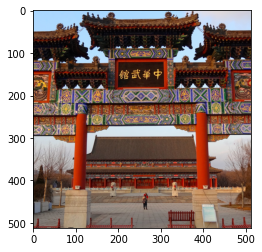

In [ ]:
#@markdown Choose the image you want to test $0\leq$ `IMG_ID` $\leq15$

IMG_ID =  0#@param

plt.imshow(dataset[IMG_ID])
plt.show()

In [ ]:
RES = 512
x1 = torch.linspace(0, 1, RES+1)[:-1]
all_data = torch.stack(torch.meshgrid(x1,x1,indexing='ij'), axis=-1)

train_label = dataset[IMG_ID][::2,::2].reshape(-1,3).to(device)

### Simple encoding
For a 1D encoder $\Phi(\cdot):\mathbb{R}\to\mathbb{R}^{K}$, simple encoding means 2D encoding are just concatenation of 1D encoding. Note that RFF different but we still place it here since the feature dimesion is still $2K$. Here is a simple implementation of common 2D encoding methods.

#### 2D encoding function

In [ ]:
class encoding_func_2D:
    def __init__(self, name, param=None):
        self.name = name

        if name == 'none': self.dim=2
        elif name == 'basic': self.dim=4
        else:
            self.dim = param[1]
            if name == 'RFF':
                self.b = param[0]*torch.randn((int(param[1]/2),2))
            elif name == 'rffb':
                self.b = param[0]
            elif name == 'Linf':
                self.b = torch.linspace(2.**0., 2.**param[0], steps=int(param[1]/4)).reshape(-1,1)
            elif name == 'Logf':
                self.b = 2.**torch.linspace(0., param[0], steps=int(param[1]/4)).reshape(-1,1)
            elif name == 'Gau2':
                self.dic = torch.linspace(0., 1, steps=int(param[1]/2)+1)[:-1].reshape(1,-1)
                self.sig = param[0]
            elif name == 'Gau4':
                self.dic = torch.linspace(0., 1, steps=int(param[1]/4)+1)[:-1].reshape(1,-1)
                self.sig = param[0]
            elif name == 'Tri2':
                self.dic = torch.linspace(0., 1, steps=int(param[1]/2)+1)[:-1].reshape(1,-1)
                if param[0] is None: self.d = 1/param[1]
                else: self.d = param[0]
            elif name == 'Tri4':
                self.dic = torch.linspace(0., 1, steps=int(param[1]/4)+1)[:-1].reshape(1,-1)
                if param[0] is None: self.d = 1/param[1]
                else: self.d = param[0]
            else:
                print('Undifined encoding!')
    def __call__(self, x):
        if self.name == 'none':
            return x
        elif self.name == 'basic':
            emb = torch.cat((torch.sin((2.*np.pi*x)),torch.cos((2.*np.pi*x))),1)
            emb = emb/(emb.norm(dim=1).max())
            return emb
        elif (self.name == 'RFF')|(self.name == 'rffb'):
            emb = torch.cat((torch.sin((2.*np.pi*x) @ self.b.T),torch.cos((2.*np.pi*x) @ self.b.T)),1)
            emb = emb/(emb.norm(dim=1).max())
            return emb
        elif (self.name == 'Linf')|(self.name == 'Logf'):
            emb1 = torch.cat((torch.sin((2.*np.pi*x[:,:1]) @ self.b.T),torch.cos((2.*np.pi*x[:,:1]) @ self.b.T)),1)
            emb2 = torch.cat((torch.sin((2.*np.pi*x[:,1:2]) @ self.b.T),torch.cos((2.*np.pi*x[:,1:2]) @ self.b.T)),1)
            emb = torch.cat([emb1,emb2],1)
            emb = emb/(emb.norm(dim=1).max())
            return emb
        elif self.name == 'Gau2':
            emb1 = (-0.5*(x[:,:1]-self.dic)**2/(self.sig**2)).exp()
            emb2 = (-0.5*(x[:,1:2]-self.dic)**2/(self.sig**2)).exp()
            emb = torch.cat([emb1,emb2],1)
            emb = emb/(emb.norm(dim=1).max())
            return emb
        elif self.name == 'Gau4':
            emb1 = (-0.5*(x[:,:1]-self.dic)**2/(self.sig**2)).exp()
            emb2 = (-0.5*(x[:,1:2]-self.dic)**2/(self.sig**2)).exp()
            emb3 = (-0.5*(0.5*(x[:,:1]+x[:,1:2])-self.dic)**2/(self.sig**2)).exp()
            emb4 = (-0.5*(0.5*(x[:,:1]-x[:,1:2]+1)-self.dic)**2/(self.sig**2)).exp()
            emb = torch.cat([emb1,emb2,emb3,emb4],1)
            emb = emb/(emb.norm(dim=1).max())
            return emb
        elif self.name == 'Tri':
            emb1 = (1-(x[:,:1]-self.dic).abs()/self.d)
            emb1 = emb1*(emb1>0)
            emb2 = (1-(x[:,1:2]-self.dic).abs()/self.d)
            emb2 = emb2*(emb2>0)
            emb = torch.cat([emb1,emb2],1)
            emb = emb/(emb.norm(dim=1).max())
            return emb
        elif self.name == 'Tri4':
            emb1 = (1-(x[:,:1]-self.dic).abs()/self.d)
            emb1 = emb1*(emb1>0)
            emb2 = (1-(x[:,1:2]-self.dic).abs()/self.d)
            emb2 = emb2*(emb2>0)
            emb3 = (1-(0.5*(x[:,:1]+x[:,1:2])-self.dic).abs()/self.d)
            emb3 = emb3*(emb3>0)
            emb4 = (1-(0.5*(x[:,:1]-x[:,1:2]+1)-self.dic).abs()/self.d)
            emb4 = emb4*(emb4>0)
            emb = torch.cat([emb1,emb2,emb3,emb4],1)
            emb = emb/(emb.norm(dim=1).max())
            return emb

#### regular MLP

In [ ]:
class MLP(nn.Module):
    def __init__(self,input_dim=2, output_dim=3, depth = 0,width= 256,bias=True,use_sigmoid = False):
        super(MLP, self).__init__()
        self.use_sigmoid = use_sigmoid
        self.mm = nn.ModuleList([])
        if depth == 0:
            self.mm.append(nn.Linear(input_dim, output_dim,bias=bias))
        else:
            self.mm.append(nn.Sequential(nn.Linear(input_dim, width,bias=bias),nn.ReLU(True)))
            for i in range(depth-1):
                self.mm.append(nn.Sequential(nn.Linear(width, width,bias=bias),nn.ReLU(True)))
            self.mm.append(nn.Sequential(nn.Linear(width, output_dim,bias=bias)))
        if use_sigmoid: self.mm.append(nn.Sigmoid())
    def forward(self, x):
        for m in self.mm:
            x = m(x)
        return x
    def name(self):
        return "MLP"

#### Set parameters and train
You can choose any encoder you want. The given paramters are good one. Here we only run for 500 epochs and it will take around 50 seconds.

In [ ]:
#@markdown Choose encoder from `Linf`, `Logf`, `RFF`, `Gau4`, `Tri4`.
encoder = 'RFF' #@param{type:'string'}
depth = 4 #@param
lr = 1e-3 #@param
epochs = 500 #@param



encoder_params = {
    'Linf':5.5,
    'Logf':5.5,
    'RFF':14,
    'Gau4':0.006,
    'Tri4':1.5/128
}

ef = encoding_func_2D(encoder,[encoder_params[encoder],512]) 
model = MLP(input_dim=ef.dim,output_dim=3,depth=depth,width=256,bias=True,use_sigmoid=False).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr, betas=(0.9, 0.999),weight_decay=1e-8)



start = time.time()
train_data = ef(all_data[::2,::2].reshape(-1,2)).to(device)

losses_ = np.zeros(epochs)
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    out = model(train_data)
    loss = criterion(out, train_label)

    loss.backward()
    losses_[epoch] = loss.item()
    optimizer.step()
end = time.time()
print('loss:{}, times:{}'.format(losses_[-1],end-start))

loss:0.004575006663799286, times:19.318098545074463


#### check the results
The result is not perfect but if we run for more epochs, it can be slighty better.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


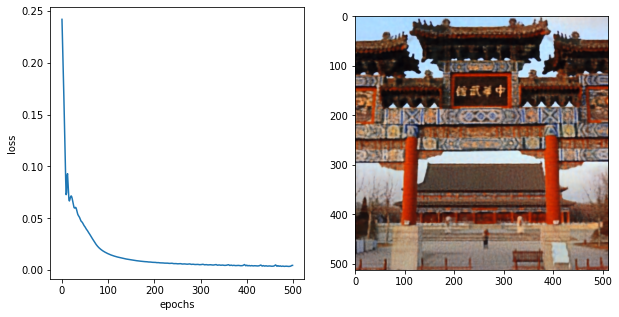

PSNR: 21.95476531982422


In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(losses_)
plt.xlabel('epochs')
plt.ylabel('loss')

with torch.no_grad():
    img_pred = model(ef(all_data.reshape(-1,2)).to(device)).reshape(RES,RES,3).detach().cpu()

plt.subplot(1,2,2)
plt.imshow(img_pred)
plt.show()
psnr = psnr_func(dataset[IMG_ID], img_pred)
print(f"PSNR: {psnr}")

### Complex encoding
For a 1D encoder $\phi(\cdot):\mathbb{R}\to\mathbb{R}^{K}$, complex encoding means 2D encoding are Kroncker product of 1D encoding. However, we don't  really need to calculate the $K^{2}$ encoding out. When this encoding multiplies a linear layer, it can be decomplosed into two small parts with the property of Kronecker product:
$$\left(\Phi\left(\mathbf{y}\right)\otimes\Phi\left(\mathbf{x}\right)\right)\mbox{vec}\left(\mathbf{W}\right)=\Phi\left(\mathbf{x}\right)\mathbf{W}\Phi\left(\mathbf{y}\right)^{T}$$

#### 1D encoding function

In [ ]:
class encoding_func_1D:
    def __init__(self, name, param=None):
        self.name = name
        
        if name == 'none': self.dim=1
        elif name == 'basic': self.dim=2
        else:
            self.dim = param[1]
            if name == 'RFF':
                self.sig = param[0]
                self.b = param[0]*torch.randn((int(param[1]/2),1))
            elif name == 'rffb':
                self.b = param[0]
            elif name == 'Linf':
                self.b = torch.linspace(2.**0., 2.**param[0], steps=int(param[1]/2)).reshape(-1,1)
            elif name == 'Logf':
                self.b = 2.**torch.linspace(0., param[0], steps=int(param[1]/2)).reshape(-1,1)
            elif name == 'Gau':
                self.dic = torch.linspace(0., 1, steps=param[1]+1)[:-1].reshape(1,-1)
                self.sig = param[0]
            elif name == 'Tri':
                self.dic = torch.linspace(0., 1, steps=param[1]+1)[:-1].reshape(1,-1)
                if param[0] is None: self.d = 1/param[1]
                else: self.d = param[0]
            else:
                print('Undifined encoding!')
    def __call__(self, x):
        if self.name == 'none':
            return x
        elif self.name == 'basic':
            emb = torch.cat((torch.sin((2.*np.pi*x)),torch.cos((2.*np.pi*x))),1)
            emb = emb/(emb.norm(dim=1).max())
            return emb
        elif (self.name == 'RFF')|(self.name == 'rffb')|(self.name == 'Linf')|(self.name == 'Logf'):
            emb = torch.cat((torch.sin((2.*np.pi*x) @ self.b.T),torch.cos((2.*np.pi*x) @ self.b.T)),1)
            emb = emb/(emb.norm(dim=1).max())
            return emb
        elif self.name == 'Gau':
            emb = (-0.5*(x-self.dic)**2/(self.sig**2)).exp()
            emb = emb/(emb.norm(dim=1).max())
            return emb
        elif self.name == 'Lin':
            emb = (1-(x-self.dic).abs()/self.d)
            emb = emb*(emb>0)
            emb = emb/(emb.norm(dim=1).max())
            return emb



#### MLP with complex encoding input
The first layer is a tensor and do mode-$n$ product with $n$th encoding.

In [ ]:
class Kron_MLP(nn.Module):
    def __init__(self,input_dim=2, output_dim=3, depth=0,width0=256,width=256, use_sigmoid=False):
        super(Kron_MLP, self).__init__()
        self.use_sigmoid = use_sigmoid
        
        if depth==0: width0 = output_dim
        
        self.mm = nn.ModuleList([])
        self.first = nn.ParameterDict({
                'weight': nn.Parameter(2/np.sqrt(width0)*torch.rand(width0, input_dim, input_dim)-1/np.sqrt(width0))})
        if depth == 1:
            self.mm.append(nn.Sequential(nn.ReLU(True),nn.Linear(width0, output_dim)))
        if depth > 1:
            self.mm.append(nn.Sequential(nn.ReLU(True),nn.Linear(width0, width),nn.ReLU(True)))
            for i in range(depth-1):
                self.mm.append(nn.Sequential(nn.Linear(width, width),nn.ReLU(True)))
            self.mm.append(nn.Linear(width, output_dim))
        if use_sigmoid: self.mm.append(nn.Sigmoid())
    def forward(self, x, y=None):
        if y is None: y=x.detach().clone()
        x = x@self.first.weight
        x = x@(y.transpose(0,1))
        x = x.flatten(1,2).transpose(0,1)
        for m in self.mm:
            x = m(x)
        return x
    def name(self):
        return "Kron_MLP"

#### Set parameters and train
You can choose any encoder you want. Shifted encoder like Gaussian or Triangle wave is better because they have higher rank. Here we only use a linear layer so `depth=0` and `lr=1e-1`.

In [ ]:
#@markdown Choose encoder from `Linf`, `Logf`, `RFF`, `Gau`, `Tri`.
encoder = 'Gau' #@param{type:'string'}

encoder_params = {
    'Linf':5.5,
    'Logf':6.5,
    'RFF':42,
    'Gau':0.003,
    'Tri':2/256
}

depth = 0 #@param
lr = 1e-1 #@param
epochs = 500 #@param

ef = encoding_func_1D(encoder,[encoder_params[encoder],256]) #@markdown Here we are using 1D encoder.
model = Kron_MLP(input_dim=ef.dim,output_dim=3,depth=0,use_sigmoid=False).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr, betas=(0.9, 0.999),weight_decay=1e-8)

start = time.time()
train_data = ef(x1[::2].reshape(-1,1)).to(device)

losses_ = np.zeros(epochs)
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    out = model(train_data)
    loss = criterion(out, train_label)

    loss.backward()
    losses_[epoch] = loss.item()
    optimizer.step()
end = time.time()
print('loss:{}, times:{}'.format(losses_[-1],end-start))

loss:7.289883797056973e-05, times:0.4501230716705322


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


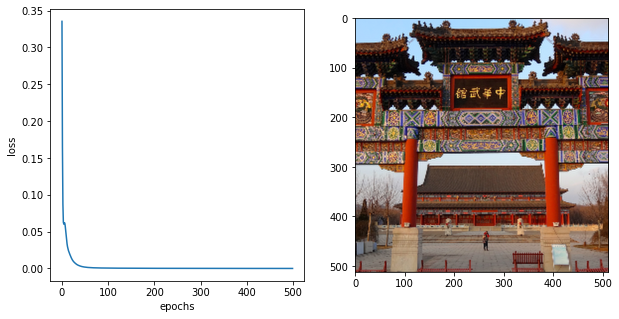

PSNR: 23.66673469543457


In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(losses_)
plt.xlabel('epochs')
plt.ylabel('loss')

with torch.no_grad():
    img_pred = model(ef(x1.reshape(-1,1)).to(device)).reshape(RES,RES,3).detach().cpu()

plt.subplot(1,2,2)
plt.imshow(img_pred)
plt.show()
psnr = psnr_func(dataset[IMG_ID], img_pred)
print(f"PSNR: {psnr}")

### Closed form solution for complex encoding
Since there is no non-linearity when we use a linear layer, the solution can be solved for closed form:
$$\mathbf{W}^{\ast} =  \left(\Phi(\mathbf{x})^{T}\Phi(\mathbf{x})\right)^{-1}\Phi(\mathbf{x})\mathbf{S}\Phi(\mathbf{y})^{T}\left(\Phi(\mathbf{y})^{T}\Phi(\mathbf{y})\right)^{-1}$$

In [ ]:
#@markdown Choose encoder from `Linf`, `Logf`, `RFF`, `Gau`, `Tri`.
encoder = 'Gau' #@param{type:'string'}

encoder_params = {
    'Linf':5.5,
    'Logf':6.5,
    'RFF':42,
    'Gau':0.003,
    'Tri':2/256
}

ef = encoding_func_1D(encoder,[encoder_params[encoder],256])
#@markdown Here we are using 1D encoder. No network is needed.

start = time.time()
train_data = ef(x1[::2].reshape(-1,1)).to(device)

#losses_ = np.zeros(epochs)
ix = torch.linalg.pinv(train_data) 
W= ix@(train_label.reshape(int(RES/2),int(RES/2),3).transpose(0,2))@ix.T

end = time.time()
print('loss:-, times:{}'.format(end-start))

loss:-, times:0.021472692489624023


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


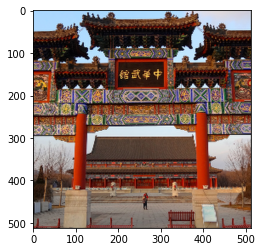

PSNR: 23.626800537109375


In [ ]:
x_all = ef(x1.reshape(-1,1)).to(device)
img_pred = (x_all@W@x_all.T).transpose(0,2).detach().cpu()

plt.imshow(img_pred)
plt.show()
psnr = psnr_func(dataset[IMG_ID], img_pred)
print(f"PSNR: {psnr}")

<a id='section_1'></a>
## 3D video reconstruction with random coordinates

Now let's try 3D dataset with random samples in the space.

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=14HT18StuPE8zGmS0I0-qgT7ZcZryEtoY
To: /content/videos_5_128.npy
100% 252M/252M [00:00<00:00, 318MB/s]


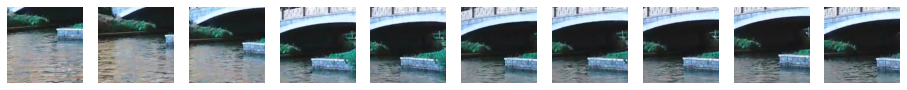

In [ ]:
!gdown --id '14HT18StuPE8zGmS0I0-qgT7ZcZryEtoY'

buf = np.load('videos_5_128.npy')

buf = torch.from_numpy(buf[0]).type(torch.FloatTensor)

plt.figure(figsize=(16,5))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(buf[12*i+4])
    plt.axis('off')
plt.show()

In [ ]:
RES = 128
x1 = torch.linspace(0, 1, RES+1)[:-1]
all_data = torch.stack(torch.meshgrid(x1,x1,x1,indexing='ij'), axis=-1)

# generate random points for training
rate = 0.125
idx = torch.randperm(RES**3)[:int(rate*RES**3)]
mask = np.zeros((RES**3))
mask[idx] = 1
mask = mask==1

train_label = buf.reshape(-1,3)[mask].to(device)

### Simple encoding

#### 3D encoding function

In [ ]:
class encoding_func_3D:
    def __init__(self, name, param=None):
        self.name = name

        if name == 'none': self.dim=2
        elif name == 'basic': self.dim=4
        else:
            self.dim = param[1]
            if name == 'RFF':
                self.b = param[0]*torch.randn((int(param[1]/2),3))
            elif name == 'rffb':
                self.b = param[0]
            elif name == 'Linf':
                self.b = torch.linspace(2.**0., 2.**param[0], steps=int(param[1]/6)).reshape(-1,1)
            elif name == 'Logf':
                self.b = 2.**torch.linspace(0., param[0], steps=int(param[1]/6)).reshape(-1,1)
            elif name == 'Gau':
                self.dic = torch.linspace(0., 1, steps=int(param[1]/3)+1)[:-1].reshape(1,-1)
                self.sig = param[0]
            elif name == 'Tri':
                self.dic = torch.linspace(0., 1, steps=int(param[1]/3)+1)[:-1].reshape(1,-1)
                if param[0] is None: self.d = 1/param[1]
                else: self.d = param[0]
            else:
                print('Undifined encoding!')
    def __call__(self, x):
        if self.name == 'none':
            return x
        elif self.name == 'basic':
            emb = torch.cat((torch.sin((2.*np.pi*x)),torch.cos((2.*np.pi*x))),1)
            emb = emb/(emb.norm(dim=1).max())
            return emb
        elif (self.name == 'RFF')|(self.name == 'rffb'):
            emb = torch.cat((torch.sin((2.*np.pi*x) @ self.b.T),torch.cos((2.*np.pi*x) @ self.b.T)),1)
            emb = emb/(emb.norm(dim=1).max())
            return emb
        elif (self.name == 'Linf')|(self.name == 'Logf'):
            emb1 = torch.cat((torch.sin((2.*np.pi*x[:,:1]) @ self.b.T),torch.cos((2.*np.pi*x[:,:1]) @ self.b.T)),1)
            emb2 = torch.cat((torch.sin((2.*np.pi*x[:,1:2]) @ self.b.T),torch.cos((2.*np.pi*x[:,1:2]) @ self.b.T)),1)
            emb3 = torch.cat((torch.sin((2.*np.pi*x[:,2:3]) @ self.b.T),torch.cos((2.*np.pi*x[:,2:3]) @ self.b.T)),1)
            emb = torch.cat([emb1,emb2,emb3],1)
            emb = emb/(emb.norm(dim=1).max())
            return emb
        elif self.name == 'Gau':
            emb1 = (-0.5*(x[:,:1]-self.dic)**2/(self.sig**2)).exp()
            emb2 = (-0.5*(x[:,1:2]-self.dic)**2/(self.sig**2)).exp()
            emb3 = (-0.5*(x[:,2:3]-self.dic)**2/(self.sig**2)).exp()
            emb = torch.cat([emb1,emb2,emb3],1)
            emb = emb/(emb.norm(dim=1).max())
            return emb
        elif self.name == 'Tri':
            emb1 = (1-(x[:,:1]-self.dic).abs()/self.d)
            emb1 = emb1*(emb1>0)
            emb2 = (1-(x[:,1:2]-self.dic).abs()/self.d)
            emb2 = emb2*(emb2>0)
            emb3 = (1-(x[:,2:3]-self.dic).abs()/self.d)
            emb3 = emb3*(emb3>0)
            emb = torch.cat([emb1,emb2,emb3],1)
            emb = emb/(emb.norm(dim=1).max())
            return emb

#### regular MLP

In [ ]:
class MLP(nn.Module):
    def __init__(self,input_dim=2, output_dim=3, depth = 0,width= 256,bias=True,use_sigmoid = False):
        super(MLP, self).__init__()
        self.use_sigmoid = use_sigmoid
        self.mm = nn.ModuleList([])
        if depth == 0:
            self.mm.append(nn.Linear(input_dim, output_dim,bias=bias))
        else:
            self.mm.append(nn.Sequential(nn.Linear(input_dim, width,bias=bias),nn.ReLU(True)))
            for i in range(depth-1):
                self.mm.append(nn.Sequential(nn.Linear(width, width,bias=bias),nn.ReLU(True)))
            self.mm.append(nn.Sequential(nn.Linear(width, output_dim,bias=bias)))
        if use_sigmoid: self.mm.append(nn.Sigmoid())
    def forward(self, x):
        for m in self.mm:
            x = m(x)
        return x
    def name(self):
        return "MLP"

#### Set parameters and train
You can choose any encoder you want. The given paramters are good one. Here we only run for 500 epochs and it will take around 50 seconds.

In [ ]:
#@markdown Choose encoder from `Linf`, `Logf`, `RFF`, `Gau`, `Tri`.
encoder = 'RFF' #@param{type:'string'}
depth = 5 #@param
lr = 5e-3 #@param
epochs =  500#@param



encoder_params = {
    'Linf':3,
    'Logf':3,
    'RFF':4,
    'Gau':0.06,
    'Tri':4.5/256
}

ef = encoding_func_3D(encoder,[encoder_params[encoder],768]) 
model = MLP(input_dim=ef.dim,output_dim=3,depth=depth,width=512,bias=True,use_sigmoid=False).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr, betas=(0.9, 0.999),weight_decay=1e-8)



start = time.time()
train_data = ef(all_data.reshape(-1,3)[mask]).to(device)

losses_ = np.zeros(epochs)
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    out = model(train_data)
    loss = criterion(out, train_label)

    loss.backward()
    losses_[epoch] = loss.item()
    optimizer.step()
end = time.time()
print('loss:{}, times:{}'.format(losses_[-1],end-start))

loss:0.0013634208589792252, times:279.5917818546295


#### check the results
The result is not perfect but if we run for more epochs, it can be slighty better.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


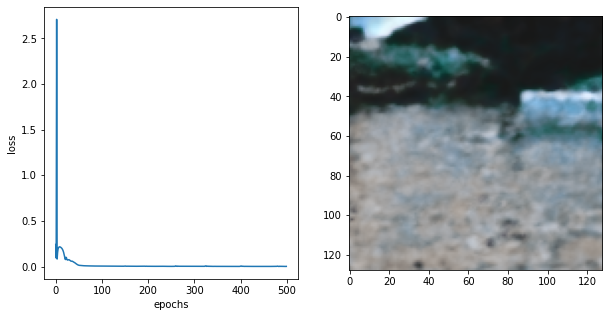

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

PSNR: 25.099132537841797


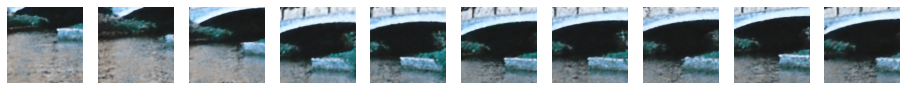

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(losses_)
plt.xlabel('epochs')
plt.ylabel('loss')

vid_pred = torch.zeros_like(buf)
with torch.no_grad():
    for i in range(16):
        vid_pred[8*i:8*(i+1)] = model(ef(all_data[8*i:8*(i+1)].reshape(-1,3)).to(device)).reshape(8,RES,RES,3).detach().cpu()

plt.subplot(1,2,2)
plt.imshow(vid_pred[0])
plt.show()
psnr = psnr_func(buf, vid_pred)
print(f"PSNR: {psnr}")

plt.figure(figsize=(16,5))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(vid_pred[12*i+4])
    plt.axis('off')
plt.show()

### Complex encoding
Similar to 2D, for separable coordinates we have,
$$\left(\Phi\left(\mathbf{z}\right)\otimes\Phi\left(\mathbf{y}\right)\otimes\Phi\left(\mathbf{x}\right)\right)\mbox{vec}\left(\mathbf{W}\right)=\mathbf{W}\times_{1}\Phi\left(\mathbf{x}\right)^{T}\times_{2}\Phi\left(\mathbf{y}\right)^{T}\times_{3}\Phi\left(\mathbf{z}\right)^{T},$$
where $\times_{n}$ means mode $n$ matrixmultiplication of tensor.
For random points in the space, we still keep this encoding for grid points as vitural grid, and then add a sparse blending matrix to approximate the encoding for random points by encoding of these grid points. The total encoding will be
$$\mathbf{B}\left(\Phi\left(\mathbf{z}\right)\otimes\Phi\left(\mathbf{y}\right)\otimes\Phi\left(\mathbf{x}\right)\right)\mbox{vec}\left(\mathbf{W}\right)=\mathbf{B}\mbox{vec}\left(\mathbf{W}\times_{1}\Phi\left(\mathbf{x}\right)^{T}\times_{2}\Phi\left(\mathbf{y}\right)^{T}\times_{3}\Phi\left(\mathbf{z}\right)^{T}\right).$$

#### 1D encoding function

In [ ]:
class encoding_func_1D:
    def __init__(self, name, param=None):
        self.name = name
        
        if name == 'none': self.dim=1
        elif name == 'basic': self.dim=2
        else:
            self.dim = param[1]
            if name == 'RFF':
                self.sig = param[0]
                self.b = param[0]*torch.randn((int(param[1]/2),1))
            elif name == 'rffb':
                self.b = param[0]
            elif name == 'Linf':
                self.b = torch.linspace(2.**0., 2.**param[0], steps=int(param[1]/2)).reshape(-1,1)
            elif name == 'Logf':
                self.b = 2.**torch.linspace(0., param[0], steps=int(param[1]/2)).reshape(-1,1)
            elif name == 'Gau':
                self.dic = torch.linspace(0., 1, steps=param[1]+1)[:-1].reshape(1,-1)
                self.sig = param[0]
            elif name == 'Tri':
                self.dic = torch.linspace(0., 1, steps=param[1]+1)[:-1].reshape(1,-1)
                if param[0] is None: self.d = 1/param[1]
                else: self.d = param[0]
            else:
                print('Undifined encoding!')
    def __call__(self, x):
        if self.name == 'none':
            return x
        elif self.name == 'basic':
            emb = torch.cat((torch.sin((2.*np.pi*x)),torch.cos((2.*np.pi*x))),1)
            emb = emb/(emb.norm(dim=1).max())
            return emb
        elif (self.name == 'RFF')|(self.name == 'rffb')|(self.name == 'Linf')|(self.name == 'Logf'):
            emb = torch.cat((torch.sin((2.*np.pi*x) @ self.b.T),torch.cos((2.*np.pi*x) @ self.b.T)),1)
            emb = emb/(emb.norm(dim=1).max())
            return emb
        elif self.name == 'Gau':
            emb = (-0.5*(x-self.dic)**2/(self.sig**2)).exp()
            emb = emb/(emb.norm(dim=1).max())
            return emb
        elif self.name == 'Tri':
            emb = (1-(x-self.dic).abs()/self.d)
            emb = emb*(emb>0)
            emb = emb/(emb.norm(dim=1).max())
            return emb



#### 3D blending fucntion

In [ ]:
class blending_func_3D:
    def __init__(self, encoding_func, dim=256,indexing=False):
        self.name = encoding_func.name
        self.dim = dim
        self.indexing = indexing
        
        # we can solve for the closed form of the correlation fuction to these encodings, orther wise it will be slow to calculate the inner profuct each time.
        if self.name == 'RFF':
            self.D = lambda x1,x2: (-2*(np.pi*(x1-x2)/(self.dim-1)*encoding_func.sig)**2).exp()
        elif self.name == 'Gau':
            self.D = lambda x1,x2: (-0.25*((x1-x2)/(self.dim-1))**2/(encoding_func.sig**2)).exp()
        elif self.name == 'Tri':
            self.D = lambda x1,x2: 0.25*torch.maximum(2*encoding_func.d-(x1-x2).abs()/(self.dim-1),torch.tensor(0))**2
        else:
            self.D = lambda x1,x2: (encoding_func(x1/(self.dim-1))*encoding_func(x2/(self.dim-1))).sum(-1).unsqueeze(1)

    def __call__(self, x):
        x = (self.dim-1)*x
        y = x[:,1:2]
        z = x[:,2:3]
        x = x[:,:1]
        xmin = torch.floor(x)
        ymin = torch.floor(y)
        zmin = torch.floor(z)

        if self.name=='RFF' or self.name=='Gau' or self.name=='Tri':
            d0 = self.D(torch.tensor([0]),torch.tensor([0]))
            dd = self.D(torch.tensor([0]),torch.tensor([1]))
            ff = d0**2-dd**2

            xda = self.D(xmin,x)
            xdb = self.D(xmin+1,x)

            xa = (xda*d0-xdb*dd)/ff
            xb = (xdb*d0-xda*dd)/ff

            yda = self.D(ymin,y)
            ydb = self.D(ymin+1,y)

            ya = (yda*d0-ydb*dd)/ff
            yb = (ydb*d0-yda*dd)/ff

            zda = self.D(zmin,z)
            zdb = self.D(zmin+1,z)

            za = (zda*d0-zdb*dd)/ff
            zb = (zdb*d0-zda*dd)/ff


            xs = xa+xb
            xa = xa/xs
            xb = xb/xs
            
            ys = ya+yb
            ya = ya/ys
            yb = yb/ys
            
            zs = za+zb
            za = za/zs
            zb = zb/zs



            N=self.dim
            Ns = x.shape[0]
            if self.indexing:
                c = torch.cat([xa*ya*za,xa*ya*zb,xa*yb*za,xa*yb*zb,xb*ya*za,xb*ya*zb,xb*yb*za,xb*yb*zb],1)
                y = torch.cat([xmin*N**2+ymin*N+zmin,xmin*N**2+ymin*N+zmin+1,xmin*N**2+(ymin+1)*N+zmin,xmin*N**2+(ymin+1)*N+zmin+1,
                                    (xmin+1)*N**2+ymin*N+zmin,(xmin+1)*N**2+ymin*N+zmin+1,(xmin+1)*N**2+(ymin+1)*N+zmin,(xmin+1)*N**2+(ymin+1)*N+zmin+1],1).type(torch.LongTensor)
                return [y,c]
            else:
                c = torch.cat([xa*ya*za,xa*ya*zb,xa*yb*za,xa*yb*zb,xb*ya*za,xb*ya*zb,xb*yb*za,xb*yb*zb],0)

                
                y = torch.cat([xmin*N**2+ymin*N+zmin,xmin*N**2+ymin*N+zmin+1,xmin*N**2+(ymin+1)*N+zmin,xmin*N**2+(ymin+1)*N+zmin+1,
                                    (xmin+1)*N**2+ymin*N+zmin,(xmin+1)*N**2+ymin*N+zmin+1,(xmin+1)*N**2+(ymin+1)*N+zmin,(xmin+1)*N**2+(ymin+1)*N+zmin+1],0).type(torch.IntTensor)
                x = torch.range(0,Ns-1,dtype=int).reshape(-1,1).repeat(8,1)
                return torch.sparse_coo_tensor(torch.cat([x,y],1).T, c.reshape(-1), (Ns, self.dim**3))

        else:
            xd0 = self.D(xmin,xmin)
            xdd = self.D(xmin,xmin+1)
            xd1 = self.D(xmin+1,xmin+1)
            xda = self.D(xmin,x)
            xdb = self.D(xmin+1,x)
            xff = xd0*xd1-xdd**2

            xa = (xda*xd1-xdb*xdd)/xff
            xb = (xdb*xd0-xda*xdd)/xff

            yd0 = self.D(ymin,ymin)
            ydd = self.D(ymin,ymin+1)
            yd1 = self.D(ymin+1,ymin+1)
            yda = self.D(ymin,y)
            ydb = self.D(ymin+1,y)
            yff = yd0*yd1-ydd**2

            ya = (yda*yd1-ydb*ydd)/yff
            yb = (ydb*yd0-yda*ydd)/yff


            zd0 = self.D(zmin,zmin)
            zdd = self.D(zmin,zmin+1)
            zd1 = self.D(zmin+1,zmin+1)
            zda = self.D(zmin,z)
            zdb = self.D(zmin+1,z)
            zff = zd0*zd1-zdd**2

            za = (zda*zd1-zdb*zdd)/zff
            zb = (zdb*zd0-zda*zdd)/zff


            xs = xa+xb
            xa = xa/xs
            xb = xb/xs
            
            ys = ya+yb
            ya = ya/ys
            yb = yb/ys
            
            zs = za+zb
            za = za/zs
            zb = zb/zs



            N=self.dim
            Ns = x.shape[0]
            if self.indexing:
                c = torch.cat([xa*ya*za,xa*ya*zb,xa*yb*za,xa*yb*zb,xb*ya*za,xb*ya*zb,xb*yb*za,xb*yb*zb],1)
                y = torch.cat([xmin*N**2+ymin*N+zmin,xmin*N**2+ymin*N+zmin+1,xmin*N**2+(ymin+1)*N+zmin,xmin*N**2+(ymin+1)*N+zmin+1,
                                    (xmin+1)*N**2+ymin*N+zmin,(xmin+1)*N**2+ymin*N+zmin+1,(xmin+1)*N**2+(ymin+1)*N+zmin,(xmin+1)*N**2+(ymin+1)*N+zmin+1],1).type(torch.LongTensor)
                return [y,c]
            else:
                c = torch.cat([xa*ya*za,xa*ya*zb,xa*yb*za,xa*yb*zb,xb*ya*za,xb*ya*zb,xb*yb*za,xb*yb*zb],0)

                
                y = torch.cat([xmin*N**2+ymin*N+zmin,xmin*N**2+ymin*N+zmin+1,xmin*N**2+(ymin+1)*N+zmin,xmin*N**2+(ymin+1)*N+zmin+1,
                                    (xmin+1)*N**2+ymin*N+zmin,(xmin+1)*N**2+ymin*N+zmin+1,(xmin+1)*N**2+(ymin+1)*N+zmin,(xmin+1)*N**2+(ymin+1)*N+zmin+1],0).type(torch.IntTensor)
                x = torch.range(0,Ns-1,dtype=int).reshape(-1,1).repeat(8,1)
                return torch.sparse_coo_tensor(torch.cat([x,y],1).T, c.reshape(-1), (Ns, self.dim**3))

#### MLP with complex encoding input
The first layer is a tensor and do mode-$n$ product with $n$th encoding.

In [ ]:
class Indexing_Blend_Kron3_MLP(nn.Module):
    def __init__(self,input_dim=2, output_dim=3, depth=0,width0=256,width=256, use_sigmoid=True):
        super(Indexing_Blend_Kron3_MLP, self).__init__()
        self.use_sigmoid = use_sigmoid
        
        if depth==0: width0 = output_dim
        
        self.mm = nn.ModuleList([])
        self.first = nn.Parameter(2/np.sqrt(width0)*torch.rand(width0, input_dim, input_dim, input_dim)-1/np.sqrt(width0))
        if depth == 1:
            self.mm.append(nn.Sequential(nn.ReLU(True),nn.Linear(width0, output_dim)))
        if depth > 1:
            self.mm.append(nn.Sequential(nn.ReLU(True),nn.Linear(width0, width),nn.ReLU(True)))
            for i in range(depth-1):
                self.mm.append(nn.Sequential(nn.Linear(width, width),nn.ReLU(True)))
            self.mm.append(nn.Linear(width, output_dim))
        if use_sigmoid: self.mm.append(nn.Sigmoid())
    def forward(self, B, x, y=None,z=None):
        
        if y is None: y=x.detach().clone()
        if z is None: z=x.detach().clone()
        x = x@self.first
        x = x@(y.transpose(0,1))
        x = z@(x.transpose(1,2))
        x = x.flatten(1,3).transpose(0,1)
        x = (x[B[0]]*(B[1].unsqueeze(-1))).sum(1)
        #x = torch.einsum('ijk,ij->ik',x[B[0]],B[1])
        for m in self.mm:
            x = m(x)
        return x
    def name(self):
        return "Indexing_Blend_Kron3_MLP" 

#### Set parameters and train
You can choose any encoder you want. Shifted encoder like Gaussian or Triangle wave is better because they have higher rank. Here we only use a linear layer so `depth=0` and `lr=1e-1`.

In [ ]:
#@markdown Choose encoder from `Linf`, `Logf`, `RFF`, `Gau`, `Tri`.
encoder = 'Gau' #@param{type:'string'}

encoder_params = {
    'Linf':4,
    'Logf':7,
    'RFF':4,
    'Gau':0.018,
    'Tri':3/64
}

depth = 0 #@param
lr = 1e-1 #@param
epochs = 500 #@param

inner_encoding = encoding_func_1D(encoder,[encoder_params[encoder],64]) #@markdown Here we are using 1D encoder.
outter_blending = blending_func_3D(inner_encoding,65,indexing=True)

all_grid = torch.linspace(0, 1, outter_blending.dim)
encoded_grid = inner_encoding(all_grid.reshape(-1,1)).to(device)

model = Indexing_Blend_Kron3_MLP(input_dim=inner_encoding.dim,output_dim=3,depth=0,use_sigmoid=False).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr, betas=(0.9, 0.999),weight_decay=1e-8)

start = time.time()
train_idx, train_wei = outter_blending(all_data.reshape(-1,3)[mask])
train_idx, train_wei = train_idx.to(device), train_wei.to(device)

losses_ = np.zeros(epochs)
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    out = model([train_idx,train_wei],encoded_grid)
    loss = criterion(out, train_label)

    loss.backward()
    losses_[epoch] = loss.item()
    optimizer.step()
end = time.time()
print('loss:{}, times:{}'.format(losses_[-1],end-start))

loss:0.0025778580456972122, times:4.492416620254517


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


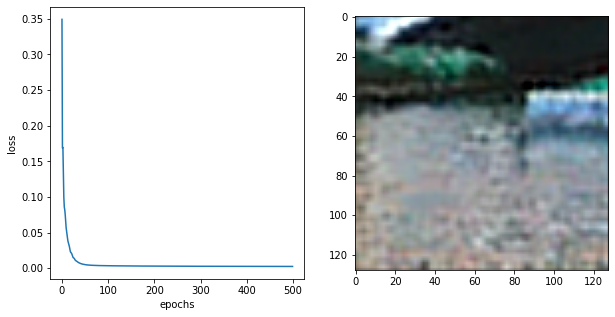

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

PSNR: 23.41170883178711


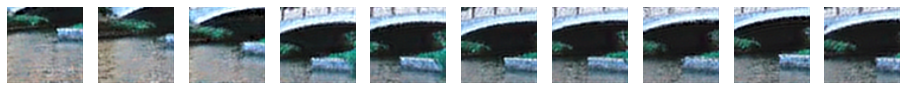

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(losses_)
plt.xlabel('epochs')
plt.ylabel('loss')

with torch.no_grad():
    all_idx,all_wei = outter_blending(all_data.reshape(-1,3))
    all_idx, all_wei = all_idx.to(device), all_wei.to(device)
    vid_pred = model([all_idx,all_wei],encoded_grid).reshape(RES,RES,RES,3).detach().cpu()

plt.subplot(1,2,2)
plt.imshow(vid_pred[0])
plt.show()
psnr = psnr_func(buf, vid_pred)
print(f"PSNR: {psnr}")

plt.figure(figsize=(16,5))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(vid_pred[12*i+4])
    plt.axis('off')
plt.show()

#### With total variation loss

In [ ]:
def smooth_3D(X):
    sx = ((X[:-1,:,:,:]-X[1:,:,:,:])**2).mean()
    sy = ((X[:,:-1,:,:]-X[:,1:,:,:])**2).mean()
    sz = ((X[:,:,:-1,:]-X[:,:,1:,:])**2).mean()
    return sx+sy+sz

In [ ]:
#@markdown Choose encoder from `Linf`, `Logf`, `RFF`, `Gau`, `Tri`.
encoder = 'Gau' #@param{type:'string'}

encoder_params = {
    'Linf':4,
    'Logf':7,
    'RFF':4,
    'Gau':0.014,
    'Tri':3/64
}

depth = 0 #@param
lr = 1e-1 #@param
epochs = 500 #@param

inner_encoding = encoding_func_1D(encoder,[encoder_params[encoder],64]) #@markdown Here we are using 1D encoder.
outter_blending = blending_func_3D(inner_encoding,65,indexing=True)

all_grid = torch.linspace(0, 1, outter_blending.dim)
encoded_grid = inner_encoding(all_grid.reshape(-1,1)).to(device)

sm = 0.05

model = Indexing_Blend_Kron3_MLP(input_dim=inner_encoding.dim,output_dim=3,depth=0,use_sigmoid=False).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr, betas=(0.9, 0.999),weight_decay=1e-8)

start = time.time()
train_idx, train_wei = outter_blending(all_data.reshape(-1,3)[mask])
train_idx, train_wei = train_idx.to(device), train_wei.to(device)

losses_ = np.zeros(epochs)
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    out = model([train_idx,train_wei],encoded_grid)
    loss = criterion(out, train_label)

    if sm>0:
        loss += sm*smooth_3D(model.first)

    loss.backward()
    losses_[epoch] = loss.item()
    optimizer.step()
end = time.time()
print('loss:{}, times:{}'.format(losses_[-1],end-start))

loss:0.003383821342140436, times:4.7470197677612305


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


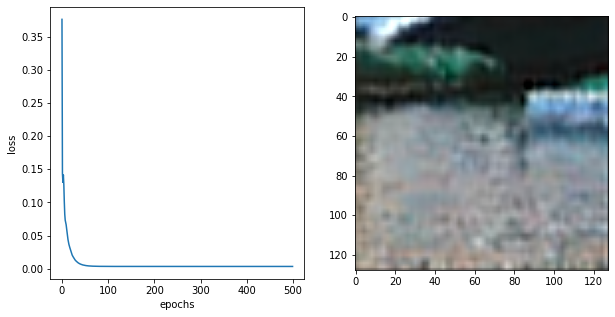

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

PSNR: 23.270910263061523


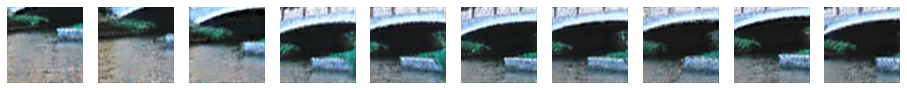

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(losses_)
plt.xlabel('epochs')
plt.ylabel('loss')

with torch.no_grad():
    all_idx,all_wei = outter_blending(all_data.reshape(-1,3))
    all_idx, all_wei = all_idx.to(device), all_wei.to(device)
    vid_pred = model([all_idx,all_wei],encoded_grid).reshape(RES,RES,RES,3).detach().cpu()

plt.subplot(1,2,2)
plt.imshow(vid_pred[0])
plt.show()
psnr = psnr_func(buf, vid_pred)
print(f"PSNR: {psnr}")

plt.figure(figsize=(16,5))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(vid_pred[12*i+4])
    plt.axis('off')
plt.show()